In [249]:
#install packages if needed
#pip install #####


#import modules
import pandas as pd
import os
import string
import nltk
nltk.download('stopwords')
import numpy as np
import matplotlib.pyplot as plt
import spacy


from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
#from corpus_toolkit import corpus_tools as ct

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lpzq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [276]:
df = pd.read_excel("Midland electrical bad actor all_Oct 2020.xlsx")

In [277]:
print(df)

                EquipmentClass    EquipmentCode  \
0     SE - Salt Water Disposal  000SCRBRSEC35DF   
1     SE - Salt Water Disposal  000SCRBRSEC35DF   
2     SE - Salt Water Disposal  000SCRBRSEC35DF   
3     SE - Salt Water Disposal  000SCRBRSEC35DF   
4     SE - Salt Water Disposal  000SCRBRSEC35DF   
...                        ...              ...   
1687              SE - Battery        UJ91VEBSB   
1688              SE - Battery    V57REYPKBTYBW   
1689              SE - Battery    V57REYPKBTYBW   
1690              SE - Battery    V57REYPKBTYBW   
1691              SE - Battery    V57REYPKBTYBW   

                                   EquipmentDescription CreatedDate  \
0     DISPOSAL; SCHARBAUER 35 SWD (AKA ELLENBERGER SWD)  2020-01-05   
1     DISPOSAL; SCHARBAUER 35 SWD (AKA ELLENBERGER SWD)  2020-01-13   
2     DISPOSAL; SCHARBAUER 35 SWD (AKA ELLENBERGER SWD)  2020-01-29   
3     DISPOSAL; SCHARBAUER 35 SWD (AKA ELLENBERGER SWD)  2020-02-26   
4     DISPOSAL; SCHARBAUER 35 SW

In [278]:
df.isnull() .sum()

EquipmentClass             0
EquipmentCode              0
EquipmentDescription       0
CreatedDate                0
FieldProductionTeam        0
WorkOrder                  0
WorkOrderDescription       0
FailureReason            108
Cause                    109
FailureReason2          1456
Comments                   0
CostCenterCode             1
NewEquipmentClass          0
GrossProductionLoss        0
MatCost                    0
WOType                     0
Trade                      0
dtype: int64

In [279]:
import re

replace_no_space = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
replace_with_space = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
tag_re = re.compile(r'<[^>]+>')

# Create transform function from long sentence to words.
def comment_to_words(comment):
    words = replace_no_space.sub("", comment.lower())
    words = replace_with_space.sub(" ", words)
    return words

def remove_tags(comment):
    return tag_re.sub('', comment)

def remove_newline(comment):
    return re.sub("\n","", comment)

In [280]:
df['Comments']

0       LWWY HIGH, LIBERTY 01-05-2020 11:02:45\n<<Defa...
1       HINS HINSZ, ELI 01-13-2020 09:23:12\n<<Default...
2       ATMQ TALAVERA, ALVINO A. 01-29-2020 15:56:31\n...
3       DKQK KEETER, DUSTIN K. 02-26-2020 15:43:46\n<<...
4       HYTD MAY, ELISSA J. 03-13-2020 08:07:22\n<<Def...
                              ...                        
1687    LHJF HERMOSILLO, LUIS 01-14-2020 10:09:39\n<<D...
1688    KYXQ EDGECOMB, KEVIN 06-25-2020 08:06:44\n<<De...
1689    GSEU SILVA, GERARDO D. 08-17-2020 18:45:14\n<<...
1690    GSEU SILVA, GERARDO D. 09-10-2020 17:19:12\n<<...
1691    KVVK MARTIN, KEVIN 09-17-2020 14:45:10\n<<Defa...
Name: Comments, Length: 1692, dtype: object

In [281]:
# Tokenizer function
tokenizer = RegexpTokenizer(r'\w+')
df['Comments'] = df['Comments'].apply(lambda x: tokenizer.tokenize(x.lower()))

In [282]:
# Remove stopwords 
stop_words = nltk.corpus.stopwords.words('english')
new_stop_words = ['default', 'pico','comment','koch','landon', 'gjmp','bracamontes','benjamin','bad','actor','requirement','inspection','failure','year','extra','cause','root','analysis','perform','please','resolve','past','repair','everything','ryan','henson','hinsz','need','cory',
                  'issue','eli','working','bbfe','rqlp','corrective','recurring','davis','jhhd', 'horton', 'jacob','herington', 'trevor', 'aol','epgu', 'corona', 'dierick','giep','luis', 'lupr', 'paiva','tfdb','tpqj', 'anderson' ,'sean','helguera' ,'sergio',
                 'stephen', 'lovell','macho','joshua','brown','phillip','pando', 'domingo', 'cesar', 'eduardo', 'cruz','jmwn', 'mendoza','jose', 'mancha', 'israel','lhjf' ,'hermosillo','tnqf' ,'mathis', 'timothy',
                 'ezhq', 'arrington' ,'anthony','baccus', 'kwade', 'fvsy', 'van', 'brian','jzrd', 'keeter', 'james','gagi', 'white' ,'gage']
stop_words.extend(new_stop_words)


def remove_stopwords(comment):
    words = [w for w in comment if w not in stop_words]
    return words

df['Comments'] = df['Comments'].apply(lambda x: remove_stopwords(x))

In [283]:
# Lemmatization 

lemmatizer = WordNetLemmatizer()

def word_lemmatizer(comment):
    lem_text = ' '.join([lemmatizer.lemmatize(word) for word in comment])
    return lem_text

df['Comments'] = df['Comments'].apply(lambda x : word_lemmatizer(x))

In [284]:
# Replace numeric with words
def replace_numeric_with_words(x):
    return re.sub(r'\d+', lambda m: "".format(len(m.group())), x)

df['Comments'] = df['Comments'].apply(replace_numeric_with_words)

In [285]:
# Split sentence to word by whitespace with no condition 
split_word_set = df['Comments'].str.lower().str.split()

# Create unique words length from set operation and count the unique words by
df['count_unique_words'] = split_word_set.apply(set).apply(len)

# Create 'count_words' columns to count
df['count_words'] = [len(sentence) for sentence in df['Comments']]

In [286]:
print (df['Comments'])
print(df.loc[0,'Comments'])

0       lwwy high liberty        repair lwwy high libe...
1       hin        repair hin       look parent work o...
2       atmq talavera alvino        repair mgky gryder...
3       dkqk dustin k        repair dkqk dustin k     ...
4       hytd may elissa j        repair hytd may eliss...
                              ...                        
1687                brownfield electrician ground main...
1688    kyxq edgecomb kevin       kyxq edgecomb kevin ...
1689    gseu silva gerardo       gseu silva gerardo   ...
1690    gseu silva gerardo        repair gseu silva ge...
1691    kvvk martin kevin        repair kvvk martin ke...
Name: Comments, Length: 1692, dtype: object
lwwy high liberty        repair lwwy high liberty       high liberty    sump run turn automatically experienced process leak sump pulled day packing leaking around piston pump cannot shut pump due running facility capacity pump go shut well unable keep level sump daily without overflowing causing environmental hin   

In [287]:
#Create DTM
cv = CountVectorizer(ngram_range = (2,3))
dtm = cv.fit_transform(df['Comments'])

words = np.array(cv.get_feature_names())
print(pd.DataFrame.from_records(dtm[:5,:5].A, columns=words[:5]))
dtm_df = pd.DataFrame.from_records(dtm.A, columns=words)

   aagian unit  aagian unit run  ab bc  ab bc ac  abandoned actuator
0            0                0      0         0                   0
1            0                0      0         0                   0
2            0                0      0         0                   0
3            0                0      0         0                   0
4            0                0      0         0                   0


In [288]:
#Look at top 50 most frequent words
freqs=dtm.sum(axis=0).A.flatten() 
index=np.argsort(freqs)[-100:] 
print(list(zip(words[index], freqs[index]))) 

WordFreq = pd.DataFrame.from_records(list(zip(words[index], freqs[index]))) 
WordFreq.columns = ['Word', 'Freq']

[('eis check', 53), ('occg calderon', 54), ('calderon oscar', 54), ('occg calderon oscar', 54), ('question call', 55), ('cycled power', 56), ('mefx eubank', 57), ('mefx eubank michael', 57), ('htkg adeyemo adewale', 57), ('htkg adeyemo', 57), ('eubank michael', 58), ('gncw rivera fermin', 59), ('gncw rivera', 59), ('larko duncan', 59), ('well communicating', 59), ('air compressor', 59), ('rivera fermin', 59), ('need replaced', 60), ('silva gerardo', 61), ('yamm hernandez yamel', 61), ('gseu silva', 61), ('gseu silva gerardo', 61), ('yamm hernandez', 61), ('caldwell zachary', 62), ('adeyemo adewale', 63), ('garcia angel', 64), ('keep going', 64), ('coih oliver colt', 65), ('lwwy high', 65), ('lwwy high liberty', 65), ('oliver colt', 65), ('coih oliver', 65), ('blown fuse', 65), ('normal order', 66), ('field specialist', 66), ('klein coleson', 67), ('hernandez yamel', 67), ('bear nicholas', 67), ('skinner skinner', 67), ('ckwt klein coleson', 67), ('ckwt klein', 67), ('rswb skinner skinn

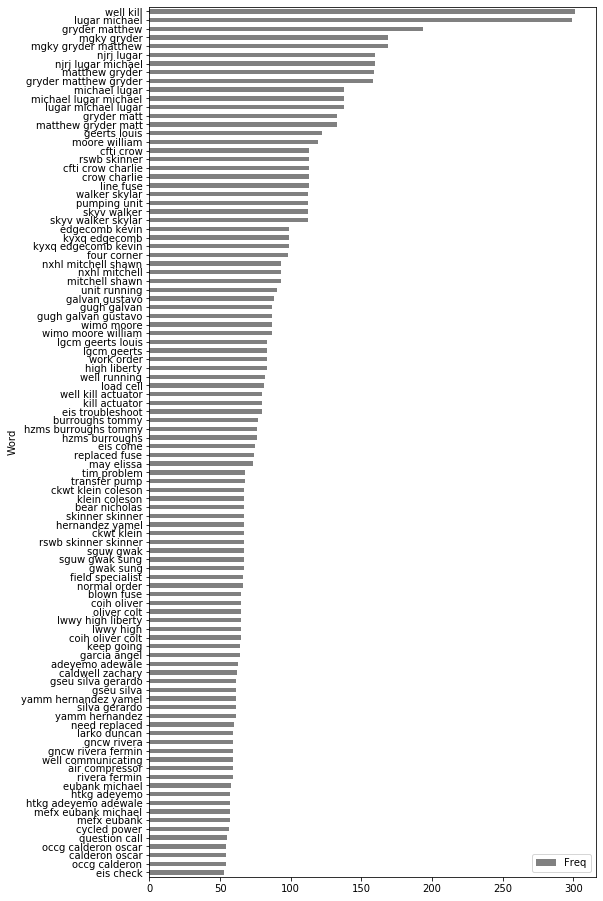

In [289]:
# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 16))
WordFreq.sort_values(by='Freq').plot.barh(x='Word',
                      y='Freq',
                      ax=ax,
                      color="gray")

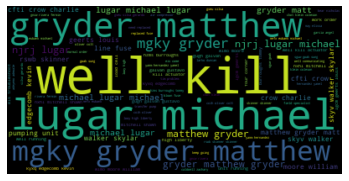

In [290]:
#Create Wordcloud
# Generate a word cloud image
data = dict(zip(WordFreq['Word'].tolist(), WordFreq['Freq'].tolist()))
wordcloud = WordCloud().generate_from_frequencies(data)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [291]:
#Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [292]:
df['WorkOrderDescription']

0       35 SWD sump pump troubleshoot why it’s not aut...
1                Follow up: tuning fork 35 swd sump pump.
2                                     35 SWD power issues
3       MBGG BRADFORD STATION FLARE IGNITOR NOT WORKIN...
4            35 SWD Sump Pump not turning off at setpoint
                              ...                        
1687    BROWNFIELD- NEED ELECTRICIAN TO GROUND THE MAI...
1688                          Replace fuses on xfmer bank
1689         Reynolds park replace burned electrical pole
1690        Reynolds park need tank automation calibrated
1691          IOC: Reynolds park Middle tank HIHI Issue .
Name: WorkOrderDescription, Length: 1692, dtype: object

In [293]:
# Tokenizer function
tokenizer = RegexpTokenizer(r'\w+')
df['WorkOrderDescription'] = df['WorkOrderDescription'].apply(lambda x: tokenizer.tokenize(x.lower()))

In [294]:
# Remove stopwords 
stop_words = nltk.corpus.stopwords.words('english')
new_stop_words = ['default', 'pico','comment','koch','landon', 'gjmp','bracamontes','benjamin','bad','actor','requirement','inspection','failure','year','extra','cause','root','analysis','perform','please','resolve','past','repair','everything','ryan','henson','hinsz','need','cory',
                  'issue','eli','working','bbfe','rqlp','corrective','recurring','davis','jhhd', 'horton', 'jacob','herington', 'trevor', 'aol','epgu', 'corona', 'dierick','giep','luis', 'lupr', 'paiva','tfdb','tpqj', 'anderson' ,'sean','helguera' ,'sergio',
                 'stephen', 'lovell','macho','joshua','brown','phillip','pando', 'domingo', 'cesar', 'eduardo', 'cruz','jmwn', 'mendoza','jose', 'mancha', 'israel','lhjf' ,'hermosillo','tnqf' ,'mathis', 'timothy',
                 'ezhq', 'arrington' ,'anthony','baccus', 'kwade', 'fvsy', 'van', 'brian','jzrd', 'keeter', 'james','gagi', 'white' ,'gage']
stop_words.extend(new_stop_words)


def remove_stopwords(comment):
    words = [w for w in comment if w not in stop_words]
    return words

df['WorkOrderDescription'] = df['WorkOrderDescription'].apply(lambda x: remove_stopwords(x))

In [295]:
# Lemmatization 

lemmatizer = WordNetLemmatizer()

def word_lemmatizer(comment):
    lem_text = ' '.join([lemmatizer.lemmatize(word) for word in comment])
    return lem_text

df['WorkOrderDescription'] = df['WorkOrderDescription'].apply(lambda x : word_lemmatizer(x))

In [296]:
# Replace numeric with words
def replace_numeric_with_words(x):
    return re.sub(r'\d+', lambda m: "".format(len(m.group())), x)

df['WorkOrderDescription'] = df['WorkOrderDescription'].apply(replace_numeric_with_words)

In [297]:
# Split sentence to word by whitespace with no condition 
split_word_set = df['WorkOrderDescription'].str.lower().str.split()

# Create unique words length from set operation and count the unique words by
df['count_unique_words_WOdes'] = split_word_set.apply(set).apply(len)

# Create 'count_words' columns to count
df['count_words_WOdes'] = [len(sentence) for sentence in df['WorkOrderDescription']]

In [298]:
print (df['WorkOrderDescription'])
print(df.loc[0,'WorkOrderDescription'])

0        swd sump pump troubleshoot automatically shut...
1                       follow tuning fork  swd sump pump
2                                         swd power issue
3           mbgg bradford station flare ignitor correctly
4                          swd sump pump turning setpoint
                              ...                        
1687        brownfield electrician ground main disconnect
1688                              replace fuse xfmer bank
1689         reynolds park replace burned electrical pole
1690             reynolds park tank automation calibrated
1691                   ioc reynolds park middle tank hihi
Name: WorkOrderDescription, Length: 1692, dtype: object
 swd sump pump troubleshoot automatically shutting


In [299]:
#Create DTM
cv = CountVectorizer(ngram_range = (2,3))
dtm = cv.fit_transform(df['WorkOrderDescription'])

words = np.array(cv.get_feature_names())
print(pd.DataFrame.from_records(dtm[:5,:5].A, columns=words[:5]))
dtm_df = pd.DataFrame.from_records(dtm.A, columns=words)

   aa fee  aa fee malfunction  aa well  aa well start  ab come
0       0                   0        0              0        0
1       0                   0        0              0        0
2       0                   0        0              0        0
3       0                   0        0              0        0
4       0                   0        0              0        0


In [300]:
#Look at top 100 most frequent words
freqs=dtm.sum(axis=0).A.flatten() 
index=np.argsort(freqs)[-100:] 
print(list(zip(words[index], freqs[index]))) 

WordFreq = pd.DataFrame.from_records(list(zip(words[index], freqs[index]))) 
WordFreq.columns = ['Word', 'Freq']

[('sat well', 10), ('fc sat', 10), ('water transfer', 10), ('ctb scharb', 10), ('gas meter', 10), ('west edge well', 10), ('bg sat', 10), ('edge well', 10), ('drive fault', 10), ('fc ctb', 10), ('scharb ls', 10), ('lost power', 10), ('com fail', 10), ('hs analyzer', 11), ('scharb need new', 11), ('sallie communicating xspoc', 11), ('sallie ctb', 11), ('dump valve', 11), ('need replaced', 11), ('bryant swd pump', 11), ('dt rpm', 11), ('bg swd', 11), ('gas lift', 11), ('flowline transmitter', 11), ('sallie communicating', 11), ('four corner sat', 12), ('communicating xspoc', 12), ('blown line', 12), ('blown line fuse', 12), ('scharb wb', 12), ('cooling fan', 12), ('field pole', 13), ('conger sale facility', 13), ('scharb need', 13), ('sale facility', 14), ('flow meter', 14), ('corner sat', 14), ('sat tester', 14), ('conger sale', 15), ('lupin satellite well', 16), ('mid ac af', 16), ('brw ctb', 16), ('lupin sat', 16), ('fee well', 16), ('electrical problem', 16), ('txl fee well', 16), ('

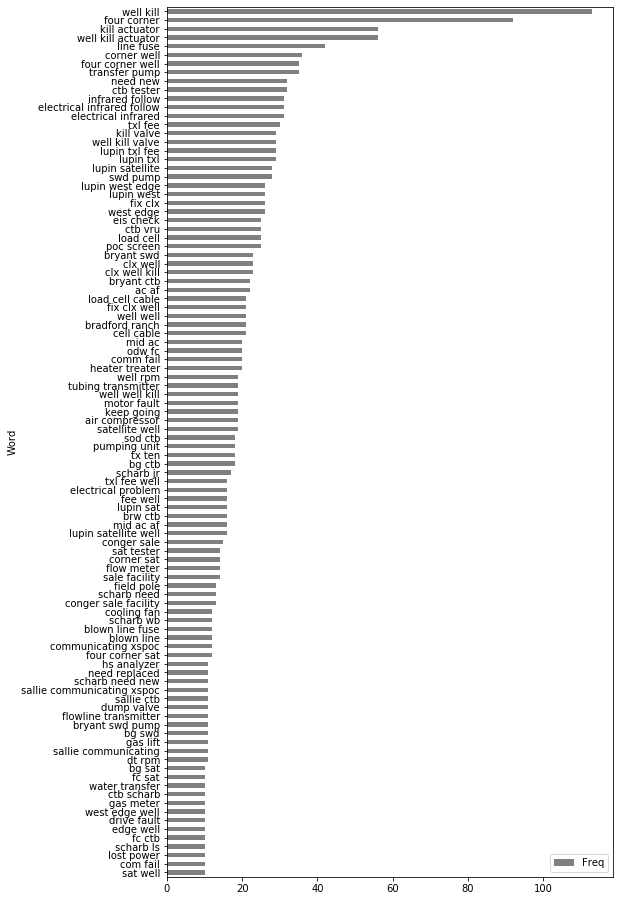

In [301]:
# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(8, 16))
WordFreq.sort_values(by='Freq').plot.barh(x='Word',
                      y='Freq',
                      ax=ax,
                      color="gray")